In [125]:
import importlib
import os
from datetime import datetime, date

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from data_collection import DataCollection

import multi_input_lsm
importlib.reload(multi_input_lsm)
from multi_input_lsm import MultiInputLSTM as lstm

import data_plotter
importlib.reload(data_plotter)
from data_plotter import DataPlotter

from algorithmic_trading.experiment_4.src import preprocessing

importlib.reload(preprocessing)
from algorithmic_trading.experiment_4.src.preprocessing import Preprocessing

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##### DATA PREPARATION #####

In [130]:
# Parameters
output_days = 100
tickers = ["GOOGL"]
start_date = "2000-01-01"
end_date = datetime.today().date()
sequence_length = 100 # todo 30, 50, 100, 365
batch_size = 32 # todo 16, 32, 64
data_path = "./data"
os.makedirs(data_path, exist_ok=True)

# Data collection
data_collector = DataCollection(tickers, start_date, end_date, folder_path=data_path)
data_collector.fetch_and_save_all()

# Preprocessing
pp = Preprocessing(folder_path=data_path, split_ratio=0.8, sequence_length=sequence_length, output_days=output_days)
x_open_train, x_high_train, x_low_train, x_close_train, x_volume_train, y_train,y_train_dates, x_open_test, x_high_test, x_low_test, x_close_test, x_volume_test, y_test, y_test_dates = pp.preprocess_pipeline()

# Convert data to PyTorch tensors
x_open_train_tensor = torch.tensor(x_open_train, dtype=torch.float32).unsqueeze(-1).to(device)
x_high_train_tensor = torch.tensor(x_high_train, dtype=torch.float32).unsqueeze(-1).to(device)
x_low_train_tensor = torch.tensor(x_low_train, dtype=torch.float32).unsqueeze(-1).to(device)
x_close_train_tensor = torch.tensor(x_close_train, dtype=torch.float32).unsqueeze(-1).to(device)
x_volume_train_tensor = torch.tensor(x_volume_train, dtype=torch.float32).unsqueeze(-1).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)

x_open_test_tensor = torch.tensor(x_open_test, dtype=torch.float32).unsqueeze(-1).to(device)
x_high_test_tensor = torch.tensor(x_high_test, dtype=torch.float32).unsqueeze(-1).to(device)
x_low_test_tensor = torch.tensor(x_low_test, dtype=torch.float32).unsqueeze(-1).to(device)
x_close_test_tensor = torch.tensor(x_close_test, dtype=torch.float32).unsqueeze(-1).to(device)
x_volume_test_tensor = torch.tensor(x_volume_test, dtype=torch.float32).unsqueeze(-1).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

# Create DataLoader for batching
train_dataset = TensorDataset(
    x_open_train_tensor, x_high_train_tensor, x_low_train_tensor, x_close_train_tensor, x_volume_train_tensor, y_train_tensor
)
test_dataset = TensorDataset(
    x_open_test_tensor, x_high_test_tensor, x_low_test_tensor, x_close_test_tensor, x_volume_test_tensor, y_test_tensor
)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

[*********************100%***********************]  1 of 1 completed


Data saved to ./data\GOOGL_data.csv


##### MODEL SETUP #####

In [131]:
input_size = 1
hidden_size = 64  # Number of hidden units in LSTM # todo 32, 50, 64, or 128
# output_size = 1  # Predicting 5 values for the next day
# num_layers = 2  # LSTM layers # todo 1 to 3
# dropout = 0.2  # Dropout rate for regularization # todo 0.1 to 0.5
learning_rate = 0.001 # todo 0.001, 0.0005, 0.0001

# Instantiate the model
model = lstm(input_sz=input_size, hidden_sz=hidden_size, output_days=output_days).to(device)

# Loss and optimizer
criterion = nn.MSELoss() # todo Mean Absolute Error (MAE = L1Loss()), Mean Squared Error (MSE)
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # todo Adam, AdamW

##### TRAINING THE MODEL #####

In [132]:
num_epochs = 50 # todo 50, 200
model.train()
for epoch in range(num_epochs):
    running_loss = 0

    for x_open, x_high, x_low, x_close, x_volume, y in train_loader:
        optimizer.zero_grad()
        outputs = model(x_open, x_high, x_low, x_close, x_volume)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader):.6f}")

Epoch 1/50, Loss: 0.018542
Epoch 2/50, Loss: 0.001581
Epoch 3/50, Loss: 0.001614
Epoch 4/50, Loss: 0.001488
Epoch 5/50, Loss: 0.001465
Epoch 6/50, Loss: 0.001439
Epoch 7/50, Loss: 0.001533
Epoch 8/50, Loss: 0.001386
Epoch 9/50, Loss: 0.001497
Epoch 10/50, Loss: 0.001463
Epoch 11/50, Loss: 0.001439
Epoch 12/50, Loss: 0.001457
Epoch 13/50, Loss: 0.001415
Epoch 14/50, Loss: 0.001402
Epoch 15/50, Loss: 0.001494
Epoch 16/50, Loss: 0.001512
Epoch 17/50, Loss: 0.001465
Epoch 18/50, Loss: 0.001438
Epoch 19/50, Loss: 0.001398
Epoch 20/50, Loss: 0.001379
Epoch 21/50, Loss: 0.001423
Epoch 22/50, Loss: 0.001487
Epoch 23/50, Loss: 0.001405
Epoch 24/50, Loss: 0.001415
Epoch 25/50, Loss: 0.001447
Epoch 26/50, Loss: 0.001379
Epoch 27/50, Loss: 0.001426
Epoch 28/50, Loss: 0.001394
Epoch 29/50, Loss: 0.001424
Epoch 30/50, Loss: 0.001368
Epoch 31/50, Loss: 0.001391
Epoch 32/50, Loss: 0.001363
Epoch 33/50, Loss: 0.001360
Epoch 34/50, Loss: 0.001357
Epoch 35/50, Loss: 0.001397
Epoch 36/50, Loss: 0.001343
E

##### EVALUATING THE MODEL #####

Test Loss: 0.2526
Sample 1:
Prediction: [1.1477693  1.1380533  1.1280231  1.1139504  1.1107326  1.1013516
 1.1036689  1.0931394  1.0714343  1.0682079  1.0666656  1.0682849
 1.0574385  1.0378342  1.0434667  1.036201   1.032285   1.018264
 1.0162603  0.99133724 0.9913337  0.9847918  0.99254113 0.986725
 0.9865756  0.9589872  0.97274995 0.9685523  0.9658635  0.9639569
 0.95711786 0.9573564  0.95106107 0.9567     0.9429073  0.93491334
 0.9498515  0.9288916  0.942665   0.9494707  0.94371176 0.94120616
 0.9302003  0.94631606 0.9451008  0.9371757  0.9391126  0.94266844
 0.9258675  0.91306734 0.9343668  0.948406   0.9344483  0.9446865
 0.94874585 0.94169915 0.94595534 0.9497219  0.95017576 0.9578706
 0.95772445 0.9812503  0.96424675 0.96882594 0.99681455 0.9783068
 0.98914915 0.9672114  0.98623997 0.9750009  0.96930623 0.9653028
 0.9653471  0.97223186 0.96941805 0.9568901  0.96390474 0.9466763
 0.9457697  0.95280904 0.95296556 0.9605316  0.95081294 0.95131886
 0.95872337 0.95042473 0.97359484 

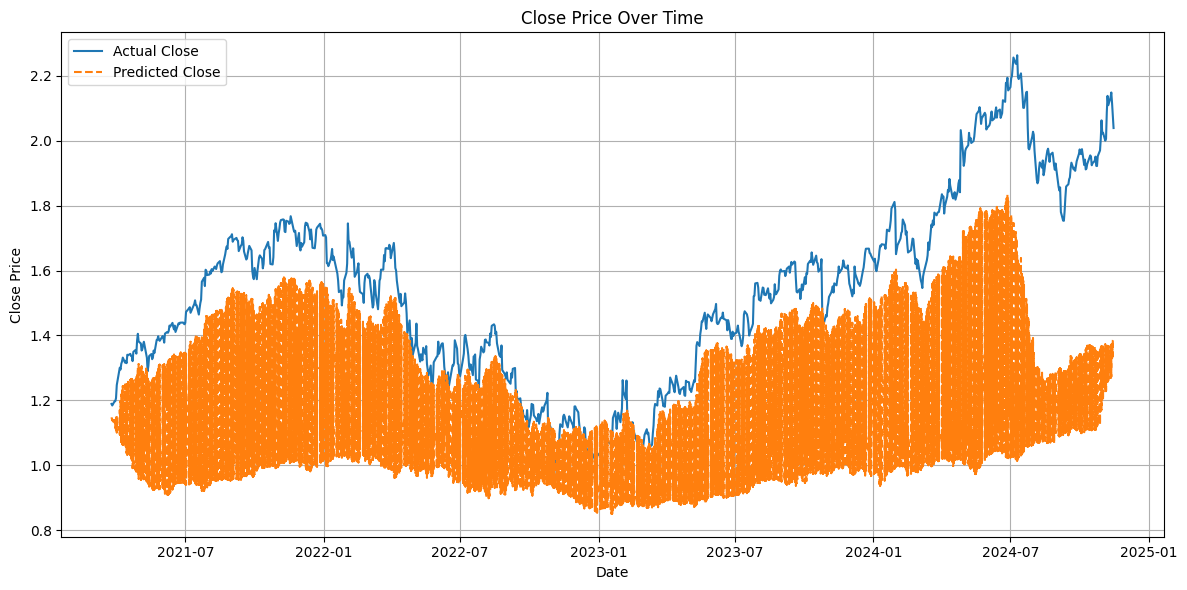

In [133]:
test_loss = 0.0
predictions = []
actuals = []

model.eval()
with torch.no_grad():
    for x_open, x_high, x_low, x_close, x_volume, y in test_loader:
        # Forward pass
        outputs = model(x_open, x_high, x_low, x_close, x_volume)
        # Compute loss
        loss = criterion(outputs.squeeze(), y)
        test_loss += loss.item()
        # Sotre predictions and actuals
        predictions.append(outputs.cpu())
        actuals.append(y.cpu())

print(f"Test Loss: {test_loss / len(test_loader):.4f}")

# Post-processing predictions and actuals for inverse scaling
predictions = torch.cat(predictions).numpy()
actuals = torch.cat(actuals).numpy()

# Inverse transform using scalers
# predictions_original = pp.scaler.inverse_transform(predictions)
# actuals_original = pp.scaler.inverse_transform(actuals)

# Print some samples for verification
for i in range(5):
    print(f"Sample {i + 1}:")
    print(f"Prediction: {predictions[i]}")
    print(f"Actual: {actuals[i]}")
    print("-" * 50)

# Plotting results
plotter = DataPlotter()
df_results = plotter.create_results_dataframe(y_test_dates, actuals, predictions)
plotter.plot_results(df_results)

##### Predict ######

In [70]:
import predictor
importlib.reload(predictor)
from predictor import Predictor

# Initialize the Predictor
predictor = Predictor(
    model=model,
    scaler=pp.scaler,
    volume_scaler=pp.volume_scaler,
    sequence_length=sequence_length,
    device=device
)

# Specify parameters for prediction
start_date = date(2023, 1, 3)

days_to_predict = 10

# Perform the prediction
dataset = pp.load_data()  # Load the dataset to access dates
dataset['Date'] = pd.to_datetime(dataset['Date']).dt.date
predicted_values_scaled = predictor.predict_future(dataset, start_date, days_to_predict)

# Extract actual values for comparison
start_index = dataset.index[dataset['Date'] == start_date][0]
actual_values = dataset.iloc[start_index + 1:start_index + 1 + days_to_predict][['Close']].values
actual_values_scaled = predictor.scale(actual_values).cpu().numpy()

# Evaluate predictions using multiple metrics
mse = np.mean((actual_values_scaled - predicted_values_scaled) ** 2)  # Mean Squared Error
mae = np.mean(np.abs(actual_values_scaled - predicted_values_scaled))  # Mean Absolute Error
variance = np.var(actual_values_scaled - predicted_values_scaled)  # Variance of errors

# Compare predicted values with actual values
print(f"\nPredictions vs Actuals starting from {start_date.strftime('%Y-%m-%d')} for {days_to_predict} days:")

for i, (prediction, actual) in enumerate(zip(predicted_values_scaled, actual_values_scaled)):
    prediction_date = dataset.iloc[start_index + 1 + i]['Date']
    # Compute changes
    predicted_change = ((prediction - actual_values_scaled[i]) / actual_values_scaled[i]) * 100
    actual_change = ((actual - actual_values_scaled[i]) / actual_values_scaled[i]) * 100
    
    print(f"Date: {prediction_date}")
    print(f"Predicted Close: {prediction}")
    print(f"Actual Close: {actual}")
    print(f"Predicted change (%): {predicted_change}")
    print(f"Actual change (%): {actual_change}") # todo is alwys 0
    print("---")
    
# Print evaluation metrics
print(f"Test Metrics:")
print(f"MSE: {mse:.6f}")  # Mean Squared Error -> Smaller values indicate better model performance.
print(f"MAE: {mae:.6f}")  # Mean Absolute Error -> Provides a more interpretable metric compared to MSE (does not square the errors).
print(f"Variance of errors: {variance:.6f}")  # Variance -> Lower variance indicates that the model consistently makes predictions close to the actual values.

# Plot
plotter = DataPlotter()
# Create a DataFrame for results
df_results = plotter.create_results_dataframe(
    dates=dataset["Date"].iloc[start_index + 1:start_index + 1 + days_to_predict],  # Use the dates for the prediction range
    actuals_original=actual_values_scaled,
    predictions_original=predicted_values_scaled
)
# Plot results for the prediction range
plotter.plot_results(df_results
)

KeyboardInterrupt: 

Simulating the "Without Predictions" Strategy

In [271]:
import random
import simulator
importlib.reload(simulator)
from simulator import InvestmentSimulator

random_index = random.randint(0, len(dataset) - 1)
values = dataset.iloc[random_index:][['Open', 'High', 'Low', 'Close', 'Volume']].values

simulator = InvestmentSimulator(
    prices=values,
    initial_capital=1000,
    profit_threshold=0.10,
    loss_threshold=-0.05,
)

print(f"Simulated buying stock in day: {dataset['Date'][random_index]}")
result = simulator.simulate()
print(result)

Simulated buying stock in day: 2011-12-19
Day 0: Profit/Loss: 0.00%
Day 1: Profit/Loss: 1.37%
Day 2: Profit/Loss: 0.64%
Day 3: Profit/Loss: 1.27%
Day 4: Profit/Loss: 1.82%
Day 5: Profit/Loss: 2.96%
Day 6: Profit/Loss: 2.87%
Day 7: Profit/Loss: 3.31%
Day 8: Profit/Loss: 3.87%
Day 9: Profit/Loss: 7.01%
Day 10: Profit/Loss: 7.47%
Day 11: Profit/Loss: 5.98%
Day 12: Profit/Loss: 4.53%
Day 13: Profit/Loss: 0.10%
Day 14: Profit/Loss: 0.21%
Day 15: Profit/Loss: 0.66%
Day 16: Profit/Loss: 1.26%
Day 17: Profit/Loss: 0.51%
Day 18: Profit/Loss: 1.09%
Day 19: Profit/Loss: 1.78%
Day 20: Profit/Loss: 2.85%
Day 21: Profit/Loss: -5.76%
{'total_stock': 64, 'stock_price': 15.56131076812744, 'days_to_threshold': 21, 'final_profit_loss': -61.47747802734375, 'status': 'loss'}


Simulating the "With Predictions" Strategy

In [260]:
import predictor
importlib.reload(predictor)
from predictor import Predictor

# Initialize Predictor
predictor = Predictor(
    model=model,  # Your trained model
    scaler=pp.scaler,
    volume_scaler=pp.volume_scaler,
    sequence_length=sequence_length,
    device=device
)

# Random day
start_date = pd.to_datetime(dataset['Date'][random_index]).date()
# Values up to day at random_index
past_values = dataset.iloc[:random_index + 1][['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]

i = 0
result = None

while result is None or result.get('status') not in ['profit', 'loss']:
    i += 1
    predicted_values, predicted_values_scaled = predictor.predict_future(past_values, start_date, i)
    
    simulator = InvestmentSimulator(
        prices=predicted_values,
        initial_capital=1000,
        profit_threshold=0.10,
        loss_threshold=-0.05,
    )
    result = simulator.simulate()
    print("---------")
    
# After the loop, print the final result
print(f"Simulated buying stock in day: {dataset['Date'][random_index]}")
print(f"Simulation completed after {i} days:")
print(result)

Day 0: Profit/Loss: 0.00%
---------
Day 0: Profit/Loss: 0.00%
Day 1: Profit/Loss: 0.29%
---------
Day 0: Profit/Loss: 0.00%
Day 1: Profit/Loss: 0.29%
Day 2: Profit/Loss: 0.58%
---------
Day 0: Profit/Loss: 0.00%
Day 1: Profit/Loss: 0.29%
Day 2: Profit/Loss: 0.58%
Day 3: Profit/Loss: 0.86%
---------
Day 0: Profit/Loss: 0.00%
Day 1: Profit/Loss: 0.29%
Day 2: Profit/Loss: 0.58%
Day 3: Profit/Loss: 0.86%
Day 4: Profit/Loss: 1.14%
---------
Day 0: Profit/Loss: 0.00%
Day 1: Profit/Loss: 0.29%
Day 2: Profit/Loss: 0.58%
Day 3: Profit/Loss: 0.86%
Day 4: Profit/Loss: 1.14%
Day 5: Profit/Loss: 1.43%
---------
Day 0: Profit/Loss: 0.00%
Day 1: Profit/Loss: 0.29%
Day 2: Profit/Loss: 0.58%
Day 3: Profit/Loss: 0.86%
Day 4: Profit/Loss: 1.14%
Day 5: Profit/Loss: 1.43%
Day 6: Profit/Loss: 1.71%
---------
Day 0: Profit/Loss: 0.00%
Day 1: Profit/Loss: 0.29%
Day 2: Profit/Loss: 0.58%
Day 3: Profit/Loss: 0.86%
Day 4: Profit/Loss: 1.14%
Day 5: Profit/Loss: 1.43%
Day 6: Profit/Loss: 1.71%
Day 7: Profit/Loss: 